<a href="https://colab.research.google.com/github/tetsnaga/FantasyFootball/blob/main/ML_Method_2_K_Means_%2B_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import argparse
import sys
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv
import torch
from torch import nn
import torch.optim as optim
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [6]:
def read_data_with_names(filename, dim, remove_outliers=True):
    x_list, y_list, all_data = [], [], []

    with open(filename) as f:
        next(f)  # Skip the first line
        headers = next(f).strip().split('\t')  # Read the second line for headers

        # Create a dictionary mapping headers to their column indexes
        header_to_index = {header: idx for idx, header in enumerate(headers)}

        for line in f:
            data = line.strip().split('\t')

            # Ensure sufficient data is present
            if len(data) < len(headers):
                print(f"Skipping line due to insufficient data: {data}")
                continue

            # Check for outliers if remove_outliers is True
            if remove_outliers and float(data[18]) == 0:  # Checking 19th column (index 18)
                continue

            # Extract player information and stats
            info = data[:4]
            stats = [float(t) for t in data[4:]]

            if dim == 1:
                x_list.append(stats[:8])  # Current season stats
                y_list.append([stats[14]])  # Next season FPTS (list of single element)
            elif dim == 5:
                x_list.append(stats[:8])  # Current season stats
                y_list.append(stats[9:14])  # Next season stats

            # Concatenate info with stats for the all_data list
            all_data.append(info + data[4:])

    return np.array(x_list), np.array(y_list), np.array(all_data), header_to_index

'''
Input:
  - Player Index
  - Headers: Default is all, can specify which headers you want
  - Return Type: Default is all, can specify if you want just X, just y, or all
Output:
  - Player Stats for specified columns (or all columns if not specified)
'''
def get_info(player_indices=None, headers=None, return_type='all', verbose=False):
    # If no indices are provided, use all indices
    if player_indices is None:
        player_indices = range(len(all_data))

    # Handle single index input for backward compatibility
    elif isinstance(player_indices, int):
        player_indices = [player_indices]

    # Initialize a list to collect data for each player index
    data_list = []

    for player_idx in player_indices:
        # Check if the player index is valid
        if player_idx >= len(all_data):
            if verbose:
                print(f"Player index {player_idx} is out of range.")
            continue

        # Collect data based on return_type and headers
        if return_type == 'X':
            if player_idx >= len(X):
                if verbose:
                    print(f"Player index {player_idx} is out of range in X.")
                continue
            if verbose:
                print(f"Player Index: {player_idx} - X Data:")
            data = [X[player_idx][i] for i, header in enumerate(headers or list(head_to_i.keys())[4:12])]
        elif return_type == 'y':
            if player_idx >= len(y):
                if verbose:
                    print(f"Player index {player_idx} is out of range in y.")
                continue
            if verbose:
                print(f"Player Index: {player_idx} - y Data: {y[player_idx]}")
            data = [y[player_idx]]
        else:  # return_type 'all' or unspecified
            if verbose:
                print(f"Player Index: {player_idx}")
            data = [all_data[player_idx][head_to_i[header]] for header in headers or head_to_i.keys()]

        # Print the data if verbose is True
        if verbose:
            for header, value in zip(headers or head_to_i.keys(), data):
                print(f"{header}: {value}")

        # Append the collected data to the data_list
        data_list.append(data)

    # Convert data_list to a 2D numpy array and return
    return np.array(data_list)

In [7]:
# Read in data along with player information
path = './data/'
filename = 'RB_Stats_Master.tsv'
X, y, all_data, head_to_i = read_data_with_names(path + filename, dim=1, remove_outliers=True)  # Remove outliers

# print(f"X.shape: {X.shape}")
# print(f"y.shape: {y.shape}")
# print("TESTING")
# print(f"X Index 20: {X[20]}")
# print(f"y Index 20: {y[20]}")

# Combine X, y, and all_data for joint shuffling
combined = list(zip(X, y, all_data))
np.random.seed(230)
np.random.shuffle(combined)

# Unzip them back
X, y, all_data = zip(*combined)
X, y = np.array(X), np.array(y)

# Split into train, dev, and test sets
split_1 = int(0.8 * len(X))
split_2 = int(0.9 * len(X))
X_train_np, y_train_np, player_info_train_np = X[:split_1], y[:split_1], all_data[:split_1]
X_dev_np, y_dev_np, player_info_dev_np = X[split_1:split_2], y[split_1:split_2], all_data[split_1:split_2]
X_test_np, y_test_np, player_info_test_np = X[split_2:], y[split_2:], all_data[split_2:]

# Normalize Data: only fit to train data so that dev/test data doesn't leak
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train_np)
X_dev_scaled = x_scaler.transform(X_dev_np)
X_test_scaled = x_scaler.transform(X_test_np)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_np)
y_dev_scaled = y_scaler.transform(y_dev_np)
y_test_scaled = y_scaler.transform(y_test_np)

# Convert scaled data to torch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float)
X_dev = torch.tensor(X_dev_scaled, dtype=torch.float)
X_test = torch.tensor(X_test_scaled, dtype=torch.float)

y_train = torch.tensor(y_train_scaled, dtype=torch.float)
y_dev = torch.tensor(y_dev_scaled, dtype=torch.float)
y_test = torch.tensor(y_test_scaled, dtype=torch.float)

# Sample Figure: Current Season Points vs Next Season Points

Scatterplot of players and the relationship between fantasy points in adjacent seasons. Points are labeled if players dropped 150 points in a season, gained 200 in a season, or surpassed 350 total for either season.

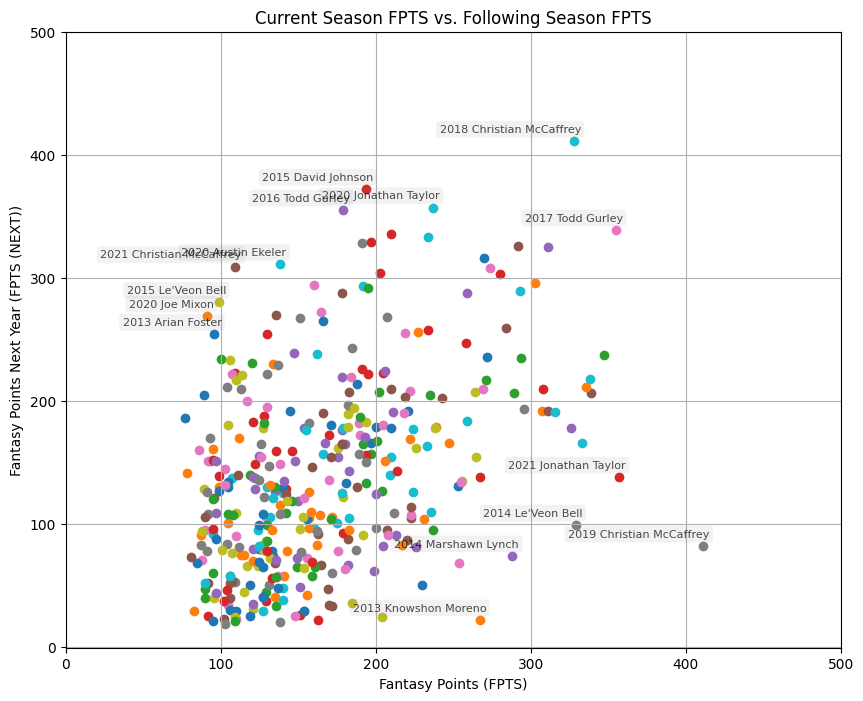

In [8]:
# Retrieve data for specific player indices
player_data = get_info(headers=["CURRENT YEAR", "NAME", "FPTS", "FPTS (NEXT)"])
# Extract headers for each player
year = player_data[:, 0]
names = player_data[:, 1]  # Assuming "NAME" is in the first column
yearname = [y + " " + n for y, n in zip(year, names)]
fpts = player_data[:, 2].astype(float)  # Assuming "FPTS" is in the second column
fpts_next = player_data[:, 3].astype(float)  # Assuming "FPTS (NEXT)" is in the third column

# Create the scatter plot
plt.figure(figsize=(10, 8))
for i, (yearname, x, y) in enumerate(zip(yearname, fpts, fpts_next)):
    plt.scatter(x, y)

    # Label specific points based on condition
    if x - y < -150 or x - y > 200 or x > 350 or y > 350:
        # Offset the text position slightly and make background transparent
        plt.annotate(yearname, (x, y), textcoords="offset points", xytext=(5,5),
                     ha='right', va='bottom', fontsize=8, alpha=0.7,
                     bbox=dict(boxstyle="round,pad=0.3", alpha=0.1, edgecolor='none', facecolor='grey'))

plt.xticks(np.linspace(0, 500, 6))
plt.yticks(np.linspace(0, 500, 6))

plt.xlabel('Fantasy Points (FPTS)')
plt.ylabel('Fantasy Points Next Year (FPTS (NEXT))')
plt.title('Current Season FPTS vs. Following Season FPTS')
plt.grid(True)
plt.show()

# ML Method 2: K-Means Clustering and Neural Network



Normalize Data

Training:
- Elbow Method: Chose k=4
- Visualize Clusters with PCA
- Train four different NN

Testing:
- Use current cluster definitions to assign to a cluster
- Feed appropriate model based on cluster number
- find loss of each model and total loss of all models

# Determine Value of K: Elbow Method

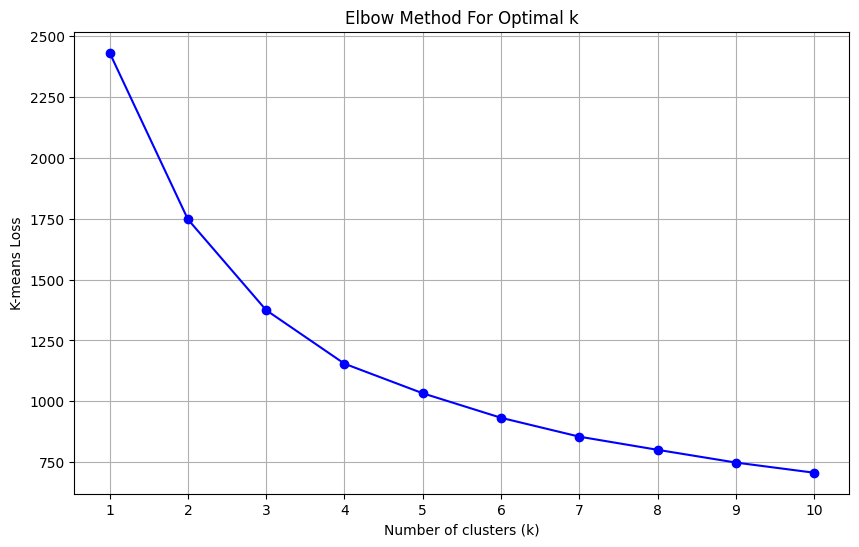

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Calculate inertia for a range of k values
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')  # Line added here
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('K-means Loss')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# PCA Visualization of Optimal K=4
We use PCA to visualize the clusters since they are in 8D space.

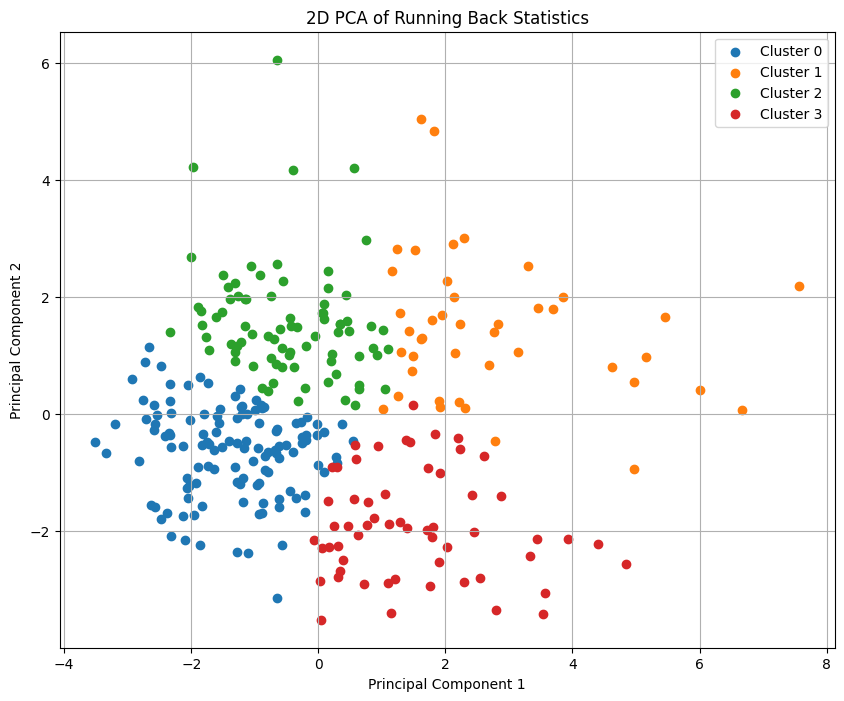

Directions of the Principal Components:
Principal Component 1: [0.22174217 0.08337955 0.08771625 0.09577459 0.51180789 0.51210752
 0.51075733 0.3767451 ]
Principal Component 2: [ 0.21309513  0.57695028  0.58135519  0.48957407 -0.09181333 -0.08292555
 -0.10494204 -0.13320302]


In [10]:
# Perform KMeans Clustering
k = 4  # Adjust as necessary
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X_train)

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Plot the PCA-reduced data with cluster labels
plt.figure(figsize=(10, 8))
for cluster in range(k):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f"Cluster {cluster}")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Running Back Statistics')
plt.legend()
plt.grid(True)
plt.show()

# Print the directions of the principal components
print("Directions of the Principal Components:")
print("Principal Component 1:", pca.components_[0])
print("Principal Component 2:", pca.components_[1])

# # Print indices of points in each cluster and their stats
# cluster_indices = {i: np.where(clusters == i)[0] for i in range(k)}
# for cluster, indices in cluster_indices.items():
#     # Call get_info with all indices in the cluster
#     player_stats = get_info(indices, headers=["CURRENT YEAR", "NAME", "FPTS", "FPTS (NEXT)"], return_type='all')
#     year = player_stats[:, 0]
#     names = player_stats[:, 1]  # Assuming "NAME" is in the first column
#     yearname = [y + " " + n for y, n in zip(year, names)]
#     fpts = player_data[:, 2].astype(float)  # Assuming "FPTS" is in the second column
#     fpts_next = player_data[:, 3].astype(float)  # Assuming "FPTS (NEXT)" is in the third column

#     print(f"\n--- Players in Cluster {cluster} ---")
#     for i in range(len(indices)):
#       if (fpts[i] > 300):
#         print(yearname[i] + ": " + str(fpts[i]) + " to " + str(fpts_next[i]))

## Comments on PCA
The Principal Components indicate the directions of the highest variance. Index 0 (G = Games Played) is almost identical for both PC1 and PC2, which makes sense since the number of games played should not have too much variance for these QBs. The rushing stats (ATT, RUSHYD, RUSHTD) are indices 1-3, with values around 0.1 for PC1 and around 0.5 for PC2. The receiving stats (TAR, REC, RECYD, RECTD) are indices 4-7, with values around 0.5 for PC1 and -0.1 for PC2.

This supports the "standard" heuristic of evaluating fantasy football runningbacks: Rushing Performance vs. Receiving Performance. This PCA is roughly approximating players on the RUSH/REC spectrum, where higher PC1 corresponds to better rushing performance, while higher PC2 corresponds to better receiving performance. We can interpret the clusters as separating the RBs into four categories: LowRush/LowRec (Red), LowRush/HighRec(Blue), HighRush/LowRec (Green), and HighRush/HighRec (Orange).

# Feed Clusters into K Models

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, width=10, depth=5, out_dim=1, activation='tanh'):
        super(MLP, self).__init__()

        # Activations
        if activation == 'tanh':
          self.activation = nn.Tanh()
        elif activation == 'sin':
          self.activation = torch.sin

        # Need to ensure there is at least one hidden layer
        assert depth > 1

        # First hidden layer
        MLP_list = [nn.Linear(input_dim, width)]

        # Remaining hidden layers
        for _ in range(depth - 1):
            MLP_list.append(nn.Linear(width, width))

        # Output layer
        MLP_list.append(nn.Linear(width, out_dim))

        # Adding list of layers as modules
        self.model = nn.ModuleList(MLP_list)

        # Weights initialization
        def init_weights(layer):
          if isinstance(layer, nn.Linear):
              nn.init.uniform_(layer.weight, -1, 1)
              if layer.bias is not None:
                nn.init.uniform_(layer.bias, -1, 1)

        self.model.apply(init_weights)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          if i < len(self.model) - 1:  # Skip the last layer, predicting values instead of probabilities
            x = self.activation(layer(x))
          else:
            x = layer(x)  # No activation in the final layer
        return x

class Sine(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

In [12]:
def train(model, optimizer, criterion, max_epochs, X_tr, y_tr, X_d, y_d):

    # Lists to store metrics for each epoch
    train_loss_history = []
    dev_loss_history = []
    dev_set_delta = []

    # Training loop
    for epoch in tqdm(range(max_epochs)):

        # Zero the gradients
        optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor s to zero.

        # Forward pass
        y_pred = model(X_tr)

        # Compute the loss
        loss = criterion(y_pred, y_tr.float())

        # Backpropagation
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves.

        # Update the weights
        optimizer.step() # Performs a single optimization step (parameter update).

        # Calculate and store training loss
        train_loss_history.append(np.sqrt(loss.item()))

        # Calculate validation loss
        with torch.no_grad():  # Disables gradient calculation
            model.eval()
            dev_pred = model(X_d)
            dev_loss = criterion(dev_pred, y_d)
            dev_loss_history.append(np.sqrt(dev_loss.item()))

            # Return to training mod
            model.train()

    return train_loss_history, dev_loss_history

def test(model, criterion, X_test, y_test):
    predictions = []
    test_loss_history = []
    with torch.no_grad():
        model.eval()
        pred = model(X_test)
        predictions.append(pred)
        test_loss = criterion(pred, y_test)
        test_loss_history.append(test_loss.item())

    for loss in test_loss_history:
        print(f"Loss: {loss}")

    return pred, test_loss_history

# Function to assign test points to the nearest cluster
def assign_cluster_to_test_point(test_point, kmeans_model):
    distances = kmeans_model.transform([test_point])
    return np.argmin(distances)

# Process Clusters to Feed into Neural Networks

In [13]:
# Split data based on cluster assignments into an array of arrays of data points
print(f"X_train.shape: {X_train.shape}")
print(f"X_dev.shape: {X_dev.shape}")

# Set Model Parameters
input_dim = 8  # RB Statistics: (GP, ATT, RUSH YD, RUSH TD, TAR, REC, REC YD, REC TD)
out_dim = 1
if (out_dim == 1):
  print("Training ML Method 1 for Total Fantasy Points")
elif (out_dim == 5):
  print("Training ML Method 1 for Total Season Stats (RUSH YD, RUSH TD, REC, REC YD, REC TD)")
else: raise ValueError

# Arbitrary Parameters
width = 10
depth = 5
learning_rate = 1e-3
reg_param = 1e-3
max_epochs = 10000

# Define Loss
criterion = nn.MSELoss()

# Initialize models and training data for each cluster
models = {}
X_train_clust = {i: X_train[clusters == i] for i in range(k)}
y_train_clust = {i: y_train[clusters == i] for i in range(k)}

# Assign dev data to nearest cluster
X_dev_np = X_dev.numpy()  # Convert to numpy for kmeans input requirement
y_dev_np = y_dev.numpy()
dev_clusters = np.array([assign_cluster_to_test_point(point, kmeans) for point in X_dev_np])
X_dev_clust = {i: X_dev_np[dev_clusters == i] for i in range(k)}
y_dev_clust = {i: y_dev_np[dev_clusters == i] for i in range(k)}

# Assign test data to nearest cluster
X_test_np = X_test.numpy()  # Convert to numpy for kmeans input requirement
y_test_np = y_test.numpy()
test_clusters = np.array([assign_cluster_to_test_point(point, kmeans) for point in X_test_np])
X_test_clust = {i: X_test_np[test_clusters == i] for i in range(k)}
y_test_clust = {i: y_test_np[test_clusters == i] for i in range(k)}

X_train.shape: torch.Size([304, 8])
X_dev.shape: torch.Size([38, 8])
Training ML Method 1 for Total Fantasy Points


# Training By Cluster

/var/folders/_1/0g3msyzx5z38rjt0jl7c2xf40000gn/T/ipykernel_27110/2740279989.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train_clust[c], dtype=torch.float)
/var/folders/_1/0g3msyzx5z38rjt0jl7c2xf40000gn/T/ipykernel_27110/2740279989.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train_clust[c], dtype=torch.float)
100%|██████████| 10000/10000 [00:03<00:00, 2593.12it/s]


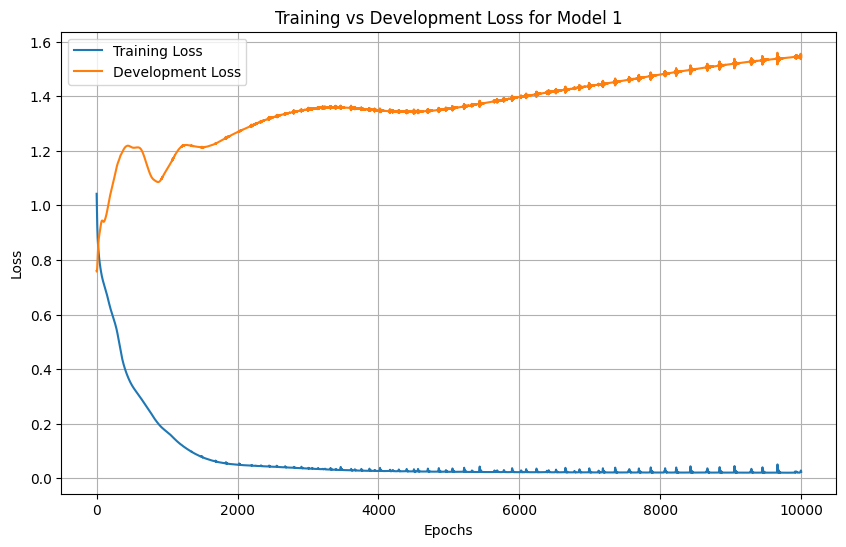

100%|██████████| 10000/10000 [00:03<00:00, 2752.42it/s]


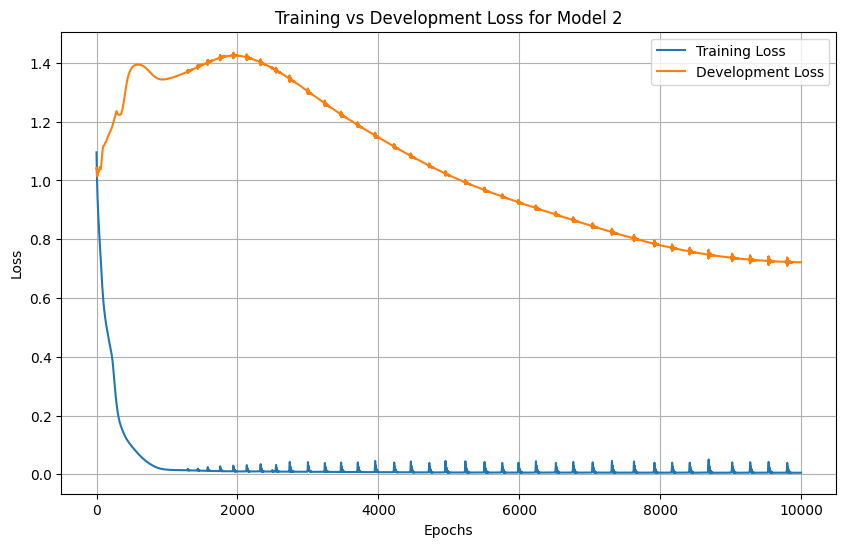

100%|██████████| 10000/10000 [00:03<00:00, 2685.89it/s]


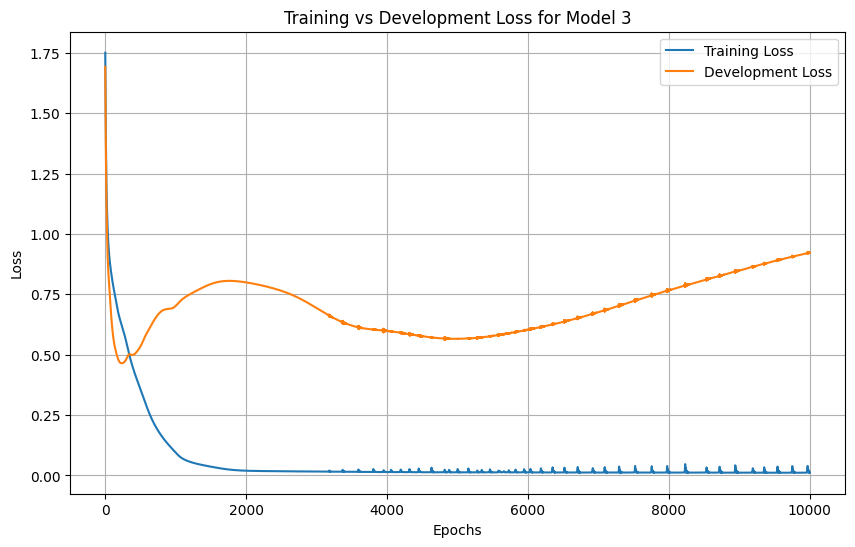

100%|██████████| 10000/10000 [00:03<00:00, 2736.84it/s]


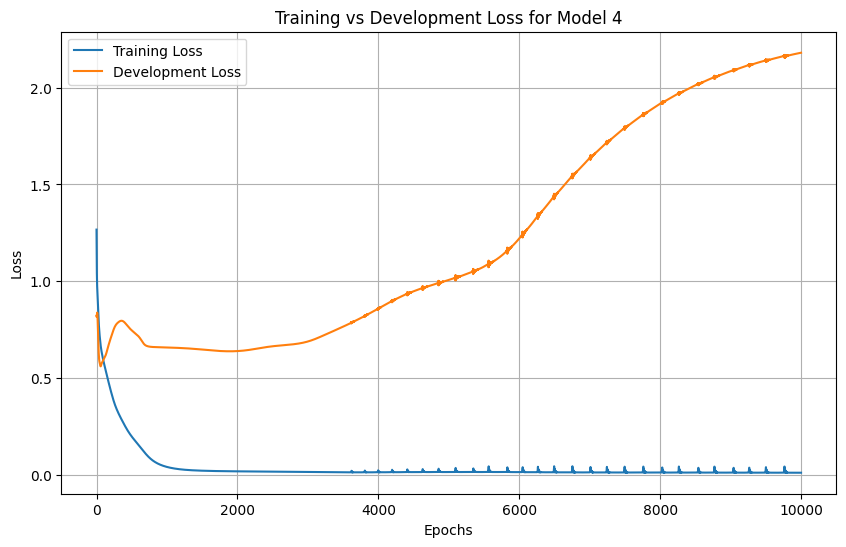

In [14]:
# Train a separate model for each cluster and plot their losses
for c in range(k):
    model = MLP(input_dim=input_dim, width=width, depth=depth, out_dim=out_dim, activation='tanh')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_param)

    X_train = torch.tensor(X_train_clust[c], dtype=torch.float)
    y_train = torch.tensor(y_train_clust[c], dtype=torch.float)

    # Load dev set data for each cluster (check to see if each cluster even has dev data just in case)
    X_dev = torch.tensor(X_dev_clust[c], dtype=torch.float) if X_dev_clust else None
    y_dev = torch.tensor(y_dev_clust[c], dtype=torch.float) if y_dev_clust else None

    train_loss_history, dev_loss_history = train(model, optimizer, criterion, max_epochs, X_train, y_train, X_dev, y_dev)
    models[c] = model

    # Plotting training and development loss for each model
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(dev_loss_history, label='Development Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training vs Development Loss for Model {c+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Testing By Cluster

Loss: 1.7781981229782104


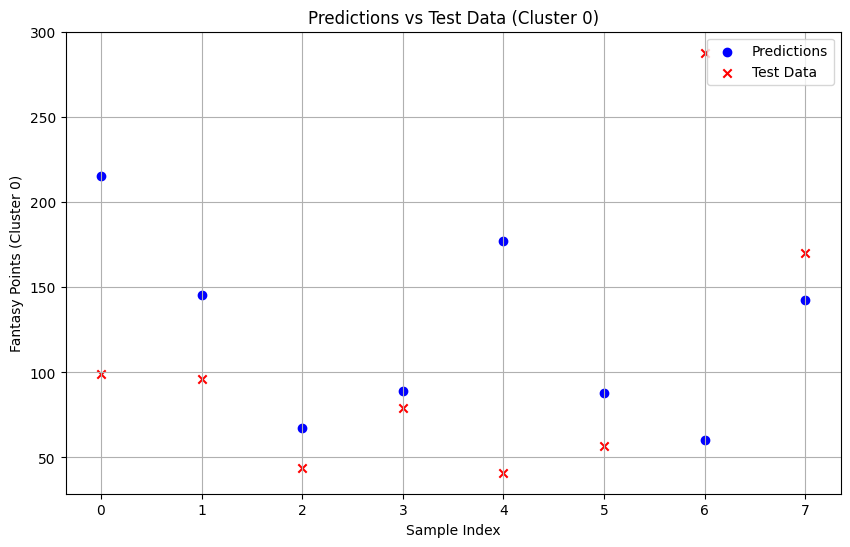

Loss: 2.2348456382751465


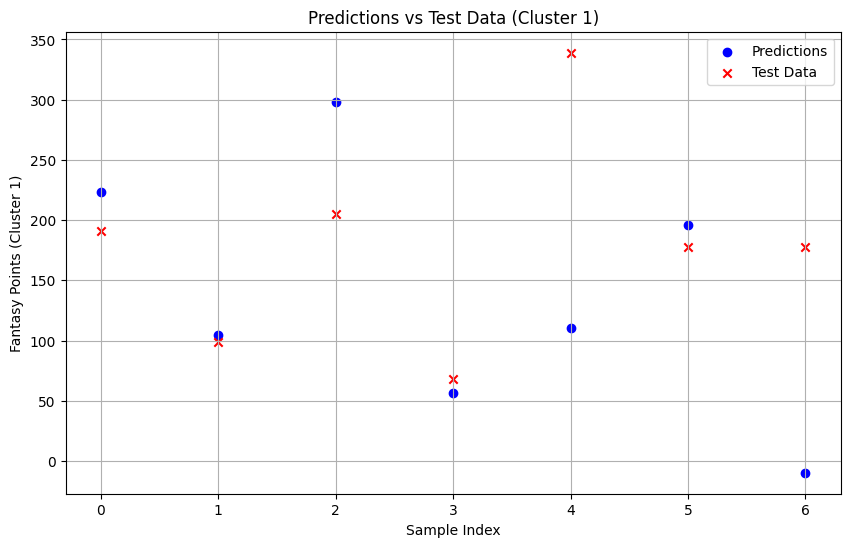

Loss: 2.284285068511963


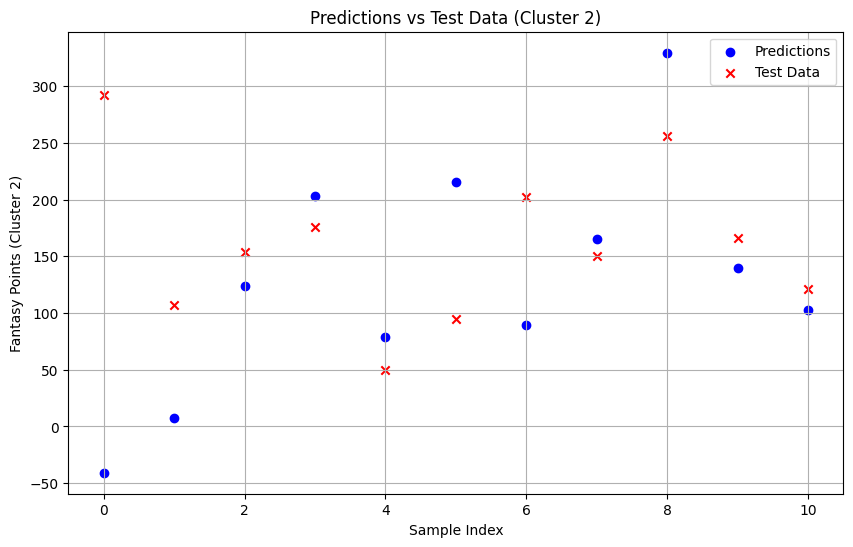

Loss: 1.8416519165039062


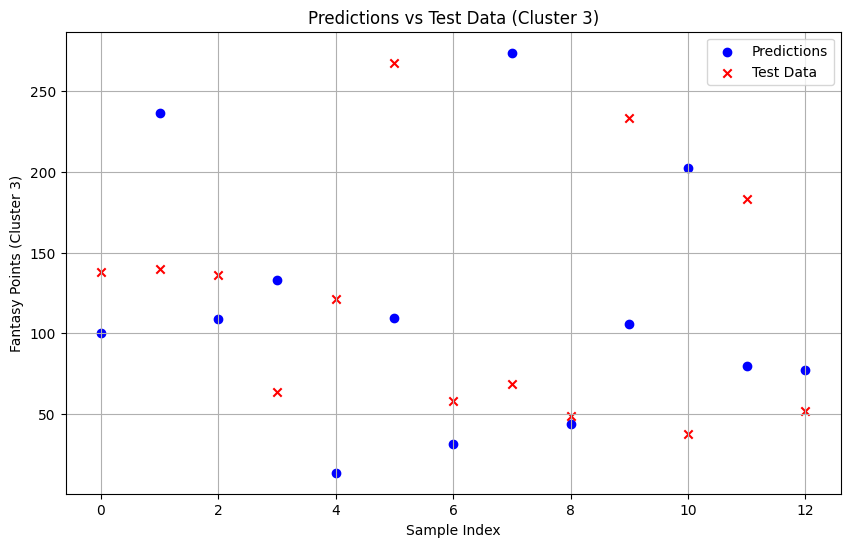

Test Loss for Cluster 0: 276.8207917284775
Test Loss for Cluster 1: 312.91141663522393
Test Loss for Cluster 2: 316.81880662971446
Test Loss for Cluster 3: 281.8357912288184
Overall Test Loss on Entire Test Set: 296.2517540814329


In [15]:
# Test each model with the corresponding test data and compute overall test loss
overall_test_loss = 0
test_loss_by_cluster = {}
for c in range(k):
    model = models[c]

    # Load test set data for each cluster (check to see if each cluster even has test data just in case)
    X_test = torch.tensor(X_test_clust[c], dtype=torch.float) if X_test_clust else None
    y_test = torch.tensor(y_test_clust[c], dtype=torch.float) if y_test_clust else None

    # print(f"X_test: {X_test}")
    # print(f"y_test: {y_test}")

    predictions, test_loss_history = test(model, criterion, X_test, y_test)

    # Calculate means and overall
    cluster_loss = np.mean(test_loss_history)

    # test_loss_by_cluster[c] = cluster_loss
    # overall_test_loss += cluster_loss * len(X_test)

    # Inverse transform the loss to the original scale
    cluster_loss_original_scale = y_scaler.inverse_transform([[cluster_loss]])[0, 0]
    test_loss_by_cluster[c] = cluster_loss_original_scale
    overall_test_loss += cluster_loss_original_scale * len(X_test_clust[c])


    # Squeeze the prediction and true value tensors to 1D arrays for plotting
    pred_1d = predictions.squeeze()
    y_test_1d = y_test.squeeze()

    # Inverse transform the predictions and true values to the original scale
    pred_1d_np = pred_1d.numpy()  # Convert to numpy array if it's a tensor
    y_test_1d_np = y_test_1d.numpy()  # Convert to numpy array if it's a tensor

    pred_1d_original = y_scaler.inverse_transform(pred_1d_np.reshape(-1, 1)).flatten()
    y_test_1d_original = y_scaler.inverse_transform(y_test_1d_np.reshape(-1, 1)).flatten()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(pred_1d_original)), pred_1d_original, label='Predictions', color='blue', marker='o')
    plt.scatter(range(len(y_test_1d_original)), y_test_1d_original, label='Test Data', color='red', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel(f'Fantasy Points (Cluster {c})')
    plt.title(f'Predictions vs Test Data (Cluster {c})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the total number of test samples
total_test_samples = sum(len(X_test_clust[c]) for c in range(k))

# Average overall test loss
overall_test_loss /= total_test_samples

# Output the test loss for each cluster and overall
for cluster, loss in test_loss_by_cluster.items():
    print(f"Test Loss for Cluster {cluster}: {loss}")
print(f"Overall Test Loss on Entire Test Set: {overall_test_loss}")



# # Average overall test loss
# overall_test_loss /= len(X_test)

# # Output the test loss for each cluster and overall
# for cluster, loss in test_loss_by_cluster.items():
#     print(f"Test Loss for Cluster {cluster}: {loss}")
# print(f"Overall Test Loss on Entire Test Set: {overall_test_loss}")


